## Two Phase Predictions Design Pattern

The Two Phased Prediction design pattern provides a way to address the problem of keeping models for specific use cases sophisticated and performant when they have to be deployed onto distributed devices. 

We'll use this [Kaggle environmental sound dataset](https://www.kaggle.com/mmoreaux/environmental-sound-classification-50?) to build a two phase model:

* Phase 1 (on-device): is it an instrument?
* Phase 2 (cloud): which instrument is it?

To build this solution, both of our models will be trained on audio [spectrograms](https://en.wikipedia.org/wiki/Spectrogram) -- image representations of audio.

In [100]:
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import tensorflow as tf

import os
import pathlib
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

### Data pre-processing

First we'll take a look at a CSV file with the audio filenames and their respective labels. Then we'll add a column for the label we'll be using in the first model to determine whether the sound is an instrument or not.

All of the data we'll be using to train the models has been made publicly available in a GCS bucket.

Inspect the labels

In [2]:
# Copy the label lookup file from GCS
!gsutil cp gs://ml-design-patterns/audio-train.csv .

Copying gs://ml-design-patterns/audio-train.csv...
/ [1 files][228.4 KiB/228.4 KiB]                                                
Operation completed over 1 objects/228.4 KiB.                                    


In [3]:
label_data = pd.read_csv('audio-train.csv')
label_data.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


Add a column for our first model: whether the sound is an instrument or not

In [4]:
instrument_labels = ['Cello', 'Clarinet', 'Double_bass', 'Saxophone', 'Violin_or_fiddle', 'Snare_drum', 'Hi-hat', 'Flute', 'Bass_drum', 'Trumpet', 'Acoustic_guitar', 'Oboe', 'Gong', 'Tambourine', 'Cowbell', 'Harmonica', 'Electric_piano', 'Glockenspiel']

In [5]:
def check_instrument(row):
  if row['label'] in instrument_labels:
    return 1
  else:
    return 0

In [6]:
label_data['is_instrument'] = label_data.apply(check_instrument, axis=1)

In [7]:
label_data.head()

,fname,label,manually_verified,is_instrument
0,00044347.wav,Hi-hat,0,1
1,001ca53d.wav,Saxophone,1,1
2,002d256b.wav,Trumpet,0,1
3,0033e230.wav,Glockenspiel,1,1
4,00353774.wav,Cello,1,1


In [8]:
label_data['is_instrument'].value_counts()

0    4761
1    4712
Name: is_instrument, dtype: int64

To ensure quality, we'll only use manually verified samples from the dataset.

In [9]:
verified = label_data.loc[label_data['manually_verified'] == 1]

In [11]:
verified['is_instrument'].value_counts()

1    2002
0    1708
Name: is_instrument, dtype: int64

In [12]:
verified.head()

,fname,label,manually_verified,is_instrument
1,001ca53d.wav,Saxophone,1,1
3,0033e230.wav,Glockenspiel,1,1
4,00353774.wav,Cello,1,1
6,003da8e5.wav,Knock,1,0
7,0048fd00.wav,Gunshot_or_gunfire,1,0


Preview the spectrogram for a sample trumpet sound from our training dataset

In [13]:
!gsutil cp gs://ml-design-patterns/audio_train/001ca53d.wav .

Copying gs://ml-design-patterns/audio_train/001ca53d.wav...
/ [1 files][888.9 KiB/888.9 KiB]                                                
Operation completed over 1 objects/888.9 KiB.                                    


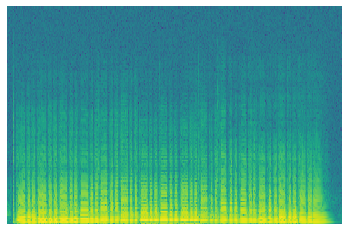

In [14]:
sample_rate, samples = wavfile.read('001ca53d.wav')
freq, times, spectro = signal.spectrogram(samples, sample_rate)
plt.figure()
fig = plt.gcf()
plt.axis('off')
plt.pcolormesh(times, freq, np.log(spectro))
plt.show()

Download all the spectrogram data

In [ ]:
# This might take a few minutes
!gsutil -m cp -r gs://ml-design-patterns/audio_train_spectro .

### Phase 1: build the offline-optimized binary classification model

First we'll move the images into labeled directories since the Keras `ImageDataGenerator` class uses this format (directories with names corresponding to labels) to read our data. Then we'll create our training and validation batches and train a model using the MobileNet V2 architecture with frozen weights from ImageNet.

In [16]:
!mkdir audio_spectros
!mkdir audio_spectros/not_instrument
!mkdir audio_spectros/instrument

In [17]:
keys = verified['fname'].values
vals = verified['is_instrument'].values
label_lookup = dict(zip(keys, vals))

In [18]:
for i in os.listdir(os.getcwd() + '/audio_train_spectro'):
  id = i.split('.')[0] + '.wav'
  is_instra = label_lookup[id]
  im_path = os.getcwd() + '/audio_train_spectro/' + i
  if is_instra == 0:
    !mv $im_path audio_spectros/not_instrument/ 
  else:
    !mv $im_path audio_spectros/instrument/

Load the images as a tf dataset

In [19]:
data_dir = pathlib.Path(os.getcwd() + '/audio')
class_names = ['not_instrument', 'instrument']

In [52]:
BATCH_SIZE = 64
IMG_HEIGHT = 128
IMG_WIDTH = 128
STEPS_PER_EPOCH = np.ceil(3700/BATCH_SIZE)

In [53]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.1)

In [54]:
train_data_gen = image_generator.flow_from_directory(directory=data_dir,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = class_names,
                                                     class_mode='binary')

Found 3710 images belonging to 2 classes.


In [55]:
val_data_gen = image_generator.flow_from_directory(directory=data_dir,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = class_names,
                                                     class_mode='binary',
                                                    subset='validation')

Found 370 images belonging to 2 classes.


In [56]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

3710


In [57]:
instrument_modellabel_batch = next(train_data_gen)

In [58]:
val_image, val_label = next(val_data_gen)

Build a model for binary classification: is it an instrument or not? We'll use **transfer learning** for this, by loading the MobileNet V2 model architecture trained on the ImageNet dataset and then adding a few additional layers on top specific to our prediction task.

In [59]:
mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=((128,128,3)), 
    include_top=False,
    weights='imagenet'
)

In [60]:
mobilenet.trainable = False

In [61]:
feature_batch = mobilenet(image_batch)

In [62]:
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_avg = global_avg_layer(feature_batch)
print(feature_batch_avg.shape)

(64, 1280)


In [63]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_avg)
print(prediction_batch.shape)

(64, 1)


In [64]:
model = tf.keras.Sequential([
  mobilenet,
  global_avg_layer,
  prediction_layer                            
])

In [65]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [66]:
model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

*Note: we could make changes to our model architecture, perform progressive fine-tuning to find the optimal number of layers to fine-tune, or employ hyperparameter tuning to improve model accuracy. Here the focus is on tooling and process rather than accuracy.*

In [ ]:
model.fit_generator(train_data_gen, 
                    validation_data=val_data_gen,
                    steps_per_epoch=STEPS_PER_EPOCH, epochs=10)

#### Convert model to TFLite and quantize

Save the TF Lite model file and get predictions on it using Python.

In [68]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
open('converted_model.tflite', 'wb').write(tflite_model)

2299368

Get a prediction on one spectrogram from our validation dataset, print the model's prediction (sigmoid probability from 0 to 1) along with ground truth label. For more details, check out the TF Lite [inference docs](https://www.tensorflow.org/lite/guide/inference).

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="converted_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array([val_image[0]], dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)
print(val_label[0])

In [76]:
input_details

[{'name': 'mobilenetv2_1.00_128_input',
  'index': 1,
  'shape': array([  1, 128, 128,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

### Phase 2: identifying instrument sounds

Train a multilabel classification model to predict the instrument associated with a given instrument sound.

In [104]:
instrument_data = verified.loc[verified['is_instrument'] == 1]

In [105]:
instrument_data.head()

,fname,label,manually_verified,is_instrument
1,001ca53d.wav,Saxophone,1,1
3,0033e230.wav,Glockenspiel,1,1
4,00353774.wav,Cello,1,1
10,006f2f32.wav,Hi-hat,1,1
14,0091fc7f.wav,Cello,1,1


In [290]:
instrument_data['label'].value_counts()

Saxophone           256
Violin_or_fiddle    250
Clarinet            130
Flute               128
Cello               125
Acoustic_guitar     105
Oboe                 99
Cowbell              96
Double_bass          92
Tambourine           92
Hi-hat               89
Harmonica            88
Trumpet              86
Gong                 85
Electric_piano       74
Snare_drum           70
Glockenspiel         70
Bass_drum            67
Name: label, dtype: int64

In [292]:
inst_keys = instrument_data['fname'].values
inst_vals = instrument_data['label'].values
instrument_label_lookup = dict(zip(inst_keys, inst_vals))

In [ ]:
!mkdir instruments

In [ ]:
for i in instrument_labels:
    path = os.getcwd() + '/instruments/' + i
    !mkdir $path

Create directories for each instrument label. We'll use this later when we load our images with Keras's `ImageDataGenerator` class.

In [299]:
for i in os.listdir(os.getcwd() + '/audio_train_spectro'):
    id = i.split('.')[0] + '.wav'
    try:
        instrument_name = instrument_label_lookup[id]
        im_path = os.getcwd() + '/audio_train_spectro/' + i
        new_path = os.getcwd() + '/instruments/' + instrument_name + '/' + i
        !mv $im_path $new_path
    except:
        pass

In [300]:
instrument_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.1)

In [303]:
BATCH_SIZE = 256
IMG_HEIGHT = 128
IMG_WIDTH = 128
STEPS_PER_EPOCH = np.ceil(2002/BATCH_SIZE)

In [304]:
train_data_instrument = instrument_image_generator.flow_from_directory(directory=os.getcwd() + '/instruments',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = instrument_labels)

Found 2002 images belonging to 18 classes.


In [305]:
val_data_instrument = instrument_image_generator.flow_from_directory(directory=os.getcwd() + '/instruments',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=False,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = instrument_labels,
                                                     subset='validation')

Found 192 images belonging to 18 classes.


In [306]:
image_instrument_train, label_instrument_train = next(train_data_instrument)

In [307]:
image_instrument_val, label_instrument_val = next(val_data_instrument)

In [322]:
vgg_model = tf.keras.applications.VGG19(
    include_top=False, 
    weights='imagenet', 
    input_shape=((128,128,3))
)

In [309]:
vgg_model.trainable = False

In [323]:
feature_batch = vgg_model(image_batch)
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_avg = global_avg_layer(feature_batch)
print(feature_batch_avg.shape)

(64, 512)


In [324]:
prediction_layer = tf.keras.layers.Dense(len(instrument_labels), activation='softmax')
prediction_batch = prediction_layer(feature_batch_avg)
print(prediction_batch.shape)

(64, 18)


In [325]:
instrument_model = tf.keras.Sequential([
    vgg_model,
    global_avg_layer,
    prediction_layer
])

In [326]:
instrument_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 18)                9234      
Total params: 20,033,618
Trainable params: 20,033,618
Non-trainable params: 0
_________________________________________________________________


In [327]:
instrument_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

*Note: we could make changes to our model architecture, perform progressive fine-tuning to find the optimal number of layers to fine-tune, or employ hyperparameter tuning to improve model accuracy. Here the focus is on tooling and process rather than accuracy.*

In [ ]:
instrument_model.fit_generator(
    train_data_instrument, 
    validation_data=val_data_instrument,
    steps_per_epoch=STEPS_PER_EPOCH, epochs=10)

#### Get a test prediction on the instrument model

In [232]:
test_pred = instrument_model.predict(np.array([image_instrument_val[0]]))

In [233]:
predicted_index = np.argmax(test_pred)
confidence = test_pred[0][predicted_index]

In [ ]:
test_pred[0]

In [ ]:
print('Predicted instrument: ', instrument_labels[predicted_index], round(confidence * 100), '% confidence')
print('Actual instrument: ', instrument_labels[np.argmax(label_instrument_val[0])])

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License